In [36]:
import pandas as pd
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
link="https://drive.google.com/open?id=1t24kiJ4Hyia1oQlkdIyuDBGFnpeBB2IF"

In [5]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1t24kiJ4Hyia1oQlkdIyuDBGFnpeBB2IF


In [74]:

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Final.csv')  
df2= pd.read_csv('Final.csv',encoding="ISO-8859-1")
df2=df2.drop(labels="body",axis=1)



InvalidConfigError: ignored

# Pre-Processing

In [75]:
import re
def remove_mentions(text):
  text = "".join([char for char in text])
  text = re.sub(r'@(\w+)', '', text, flags=re.MULTILINE)
  return text
df2['title'] = df2['title'].apply(lambda x: remove_mentions(x))

In [76]:
import string
string.punctuation
import re
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

df2['title'] = df2['title'].apply(lambda x: remove_punct(x))

In [77]:
def remove_url(text):
    text  = "".join([char for char in text])
    text = re.sub(r'http\S+', '', text, flags=re.MULTILINE)
    return text

df2['title'] = df2['title'].apply(lambda x: remove_url(x))

In [78]:
import nltk
from nltk.tokenize import word_tokenize 
nltk.download('stopwords')
#nltk.download('punkt')
stopword = set(nltk.corpus.stopwords.words('english'))
def remove_stopwords(text):
    word_tokens = word_tokenize(text) 
    text = [word for word in word_tokens if word not in stopword]
    text1=" "
    return (text1.join(text)) 
    
#df2['title'] = df2['title'].apply(lambda x: remove_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


User Defined Function for Tokenization

In [79]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

Assigning Numbers To the Categorical Variable

In [80]:
df2["Category"]= df2["Category"].replace("Safe To Ignore", 0) 
df2["Category"]= df2["Category"].replace("Concerned", 1)
df2["Category"]= df2["Category"].replace("Strongly Concerned", 2)  

# **Visualizations**

# **Word Cloud**
Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud. 

In [17]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df2.title: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

In [32]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black',stopwords = stopwords,  
                min_font_size = 10).generate(comment_words) 

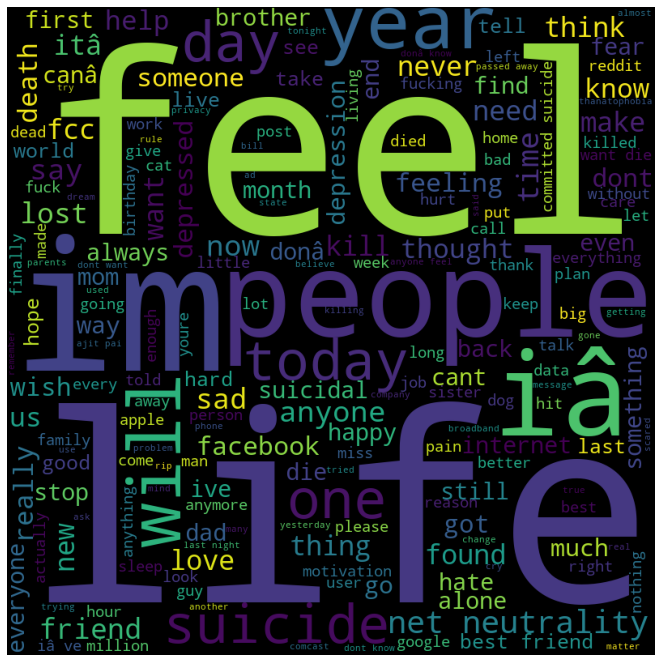

In [34]:
plt.figure(figsize = (9,9), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [52]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# **The distribution of top unigrams**

In [90]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df2['title'], 20)
df7 = pd.DataFrame(common_words, columns = ['title' , 'count'])
#df7.groupby('title').sum()['count'].sort_values(ascending=False)

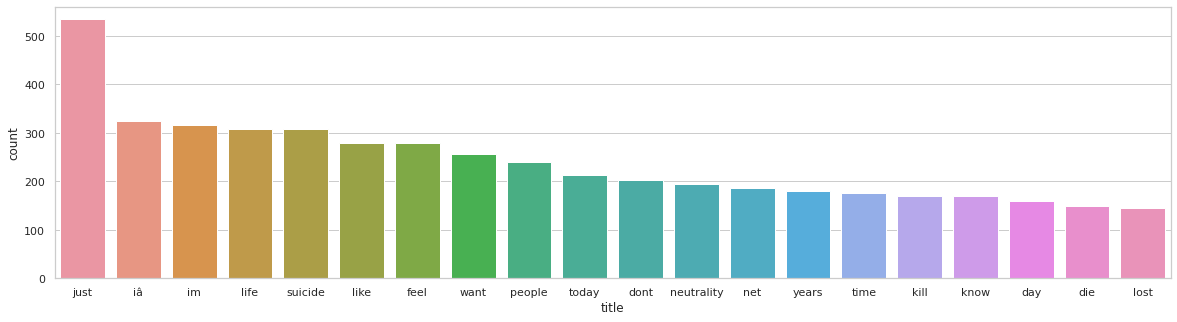

In [87]:
plt.figure(figsize=(20,5))
sns.set(style="whitegrid")
ax = sns.barplot(x="title", y="count", data=df7)

# **The distribution of top bigrams**

In [91]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df2['title'], 20)
df8 = pd.DataFrame(common_words, columns = ['title' , 'count'])
#df8.groupby('title').sum()['count'].sort_values(ascending=False)

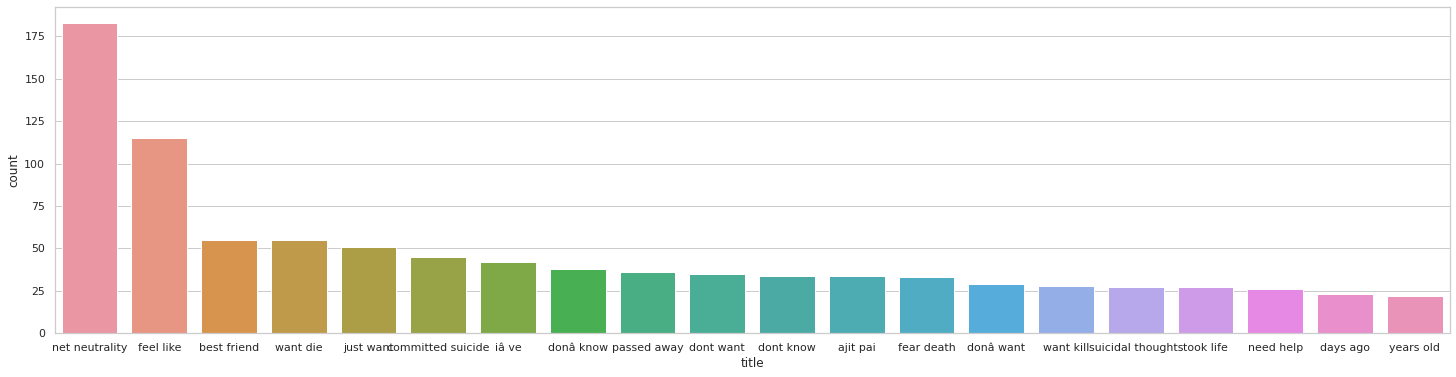

In [92]:
plt.figure(figsize=(25,6))
sns.set(style="whitegrid")
ax = sns.barplot(x="title", y="count", data=df8)

# Training the model

In [103]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df2['title'].values, 
                 df2['Category'].values,        
                 test_size=0.2)

In [104]:

vect = CountVectorizer(tokenizer=tokenization,ngram_range=(1, 2))
tf_train = vect.fit_transform(X_train)
tf_test = vect.transform(X_test)

In [105]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=0.2, dual=False)
model.fit(tf_train, y_train)
preds = model.predict(tf_test)
accuracy = ((preds == y_test).mean() )*100

## Training and Testing Carried Out and Accuracy Obtained

In [106]:
print(accuracy)

71.0


## Tweet Fetching For Classification using TWEEPY

In [107]:
import tweepy 

In [108]:
consumer_key = "L2qFoCZWuzrAeNgu9jWXuR11Z"
consumer_secret = "BkbJyNa90JKEKeFhkGQ2yKDaMG7geOxuBsrCMwz1oOt0zQF7By"
access_key = "1221670879999885312-oXJPV5PJJihL3A5bj6fFyjd7uLaZ5X"
access_secret = "FUDpsoNcnhAjEhLh0R3kiqucms8Rp60Isg0XrrxFtkuMQ"

tmp=[]
def get_tweets(username): 
		
		auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 

		auth.set_access_token(access_key, access_secret) 

		api = tweepy.API(auth) 
  
		number_of_tweets=50
		tweets = api.user_timeline(screen_name=username, count = 200, exclude_replies=1) 

		tweets_for_csv = [tweet.text for tweet in tweets] 
		for j in tweets_for_csv: 

			tmp.append(j) 

In [109]:
thandle=input()

sadhguruJV


In [162]:
get_tweets(thandle) 
df=pd.DataFrame(tmp)
df.columns = ["Tweet"]
df.head()

,Tweet
0,If you gain enough mastery over yourself and d...
1,#Life #Adventure #DailyWisdom https://t.co/Cnz...
2,"Wherever you are, whatever you do – This Is Th..."
3,Namaskaram Ramesh ji - it is my wish &amp; my ...
4,The ability to embrace the Elements as a Force...


## Preprocessing Input

In [163]:
df['Tweet'] = df['Tweet'].apply(lambda x: remove_mentions(x))

In [164]:
df['Tweet'] = df['Tweet'].apply(lambda x: remove_punct(x))

In [165]:
df['Tweet'] = df['Tweet'].apply(lambda x: remove_url(x))

In [166]:
#df['Tweet'] = df['Tweet'].apply(lambda x: remove_stopwords(x))

# Predicting The Category

In [167]:
df['Category']=model.predict(vect.transform(df['Tweet']))

In [168]:
def Category1(x):
  if(x==0):
    return "Safe To Ignore"
  elif(x==1):
    return "Concerned"
  elif(x==2):
    return "Strongly Concerned"

In [169]:
classification={0:"Safe To Ignore",1:"Concerned",2:"Strongly Concerned"}
df['Category']=[classification[item] for item in df['Category']]

In [182]:
df['Category'].value_counts().idxmax()

'Safe To Ignore'

In [180]:
maxcount=df['Category'].value_counts().idxmax()

In [171]:
l=df['Category'].value_counts()
l=l.to_frame()
l.reset_index(level=0, inplace=True)
l.rename(columns = {'index':'Category','Category':'Count'}, inplace = True) 

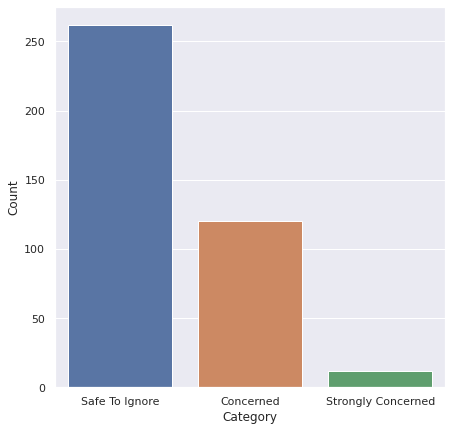

In [190]:
plt.figure(figsize=(7,7))
sns.set(style="darkgrid")
ax = sns.barplot(x="Category", y="Count", data=l)

In [227]:
print(maxcount)

Safe To Ignore
